### Библиотеки

In [1]:
import pickle

In [2]:
from Experiment_6_part2_advection import *

### Описание эксперимента:

######  - Разбираюсь со сдвигом по врмени

In [3]:
def count_ones(v_coarse,verbose=False):
    
    all_sums=[]
    for j in range(0,len(v_coarse[0,:]),1):
        all_sums.append(v_coarse[:,j].sum())
    
    if verbose:
        print(all_sums)
    assert np.sum(all_sums)%v_coarse.shape[1]==0, 'Неправильно подобран n'
    return all_sums[0]

def check_ones_continuous(v_coarse_orig,ones,verbose=False,plt_flg=False):
    
    v_coarse=copy.copy(v_coarse_orig)
    v_coarse_shifted=v_coarse.T[1:]
    v_coarse=v_coarse.T[:-1]
    diff=v_coarse_shifted-v_coarse
    
    ones=int(ones)
    
    def my_plot(k):
        plt.figure(figsize=(10,6))
        plt.plot(v_coarse[k],'-*',color='red',label='t')
        plt.plot(v_coarse_shifted[k],'--*',color='green',label='t+1')
        plt.title(k)
        plt.legend()
        plt.grid()
        plt.show()
    
    for k in range(len(v_coarse)):
        
        start=np.where(diff[k]==-1)[0]
        end=np.where(diff[k]==1)[-1]
        
        if len(start)==1 or len(end)==1:
            
            start=start[0]
            end=end[0] 
            diff_mask=diff[k][start:end+1]
            
            if plt_flg:
                my_plot(k)
                
            if verbose==True:
                print(start,end)
                print('mask',diff_mask)
            

            if len(diff_mask)!=len(np.array([-1]+[0]*(ones-1)+[1])):
                assert 1==2, 'Не выполняется условие непрерывности (длина)'
            elif (diff_mask!=np.array([-1]+[0]*(ones-1)+[1])).all():
                if verbose:
                    display(diff_mask)
                assert 1==2, 'Не выполняется условие непрерывности (значения)'
        
        elif len(start)>1:
            if plt_flg:
                my_plot(k)
            if verbose==True:
                print(start,end)
            assert 1==2,'stop point 1_start'
            
        elif len(start)<1:
            if plt_flg:
                my_plot(k)
            if verbose==True:
                print(start,end)
            assert 1==2,'stop point 2_start'
                
        elif len(end)>1:
            print()
            if plt_flg:
                my_plot(k)
            if verbose==True:
                print(start,end)
            assert 1==2,'stop point 2_end'
                
        # elif len(end)<1:
        #     print('2_end')
        #     if plt_flg:
        #         my_plot(k)
        
        # else:
            # break

### 0. Параметры для генерации данных

In [4]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=21 #число узлов
# n=41 #число узлов
# n=81 #число узлов
# n=161
# n=321

L=1 # длина расчт области
# T=.85 #конечное время
T=0.8#+L/(n-1)
kurant=1

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# b=4
v=[1 if i in range(int(b/2),int(b)+int(b/2)) else 0 for i in range(0,n) ]
print('Доля единиц:',np.round(100*v.count(1)/len(v),3))

Доля единиц: 9.524


In [5]:
epochs_lst=[10_000]

### 1. Генерация данных

In [6]:
v_fact,x_lst,tau,time_lst=generate_data_fixe(generate_flg,v,T,L,1,h,n,CUSTOM_TAU=h,save_flg=False)

Генерация данных
17 21
21 17


In [7]:
print(v_fact.shape[1],len(time_lst))
assert v_fact.shape[1]==len(time_lst),'Размерности'

17 17


Text(0.5, 1.0, 'Фактические данные')

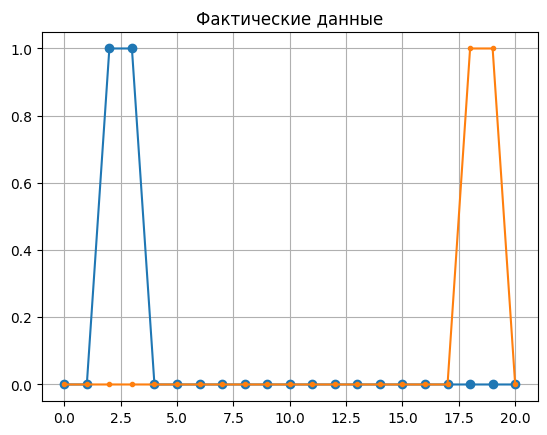

In [8]:
#view
plt.plot(v_fact[:,0],'o-')
plt.plot(v_fact[:,-1],'.-')
plt.grid()
plt.title('Фактические данные')

### 2. Сабсемплинг

In [9]:
t_factor = 1  # time subsample factor 
s_factor = 1  # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (21, 17)
train (21, 8)
test (21, 9)


In [10]:
dxc==dtc, dxc

(True, 0.05)

Text(0.5, 1.0, 'Фактические данные после сабсемплинга')

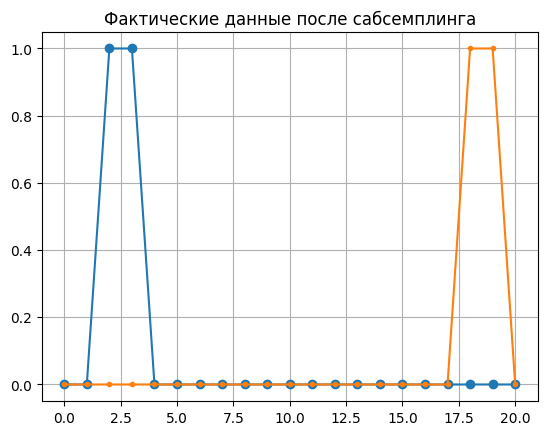

In [11]:
#view
plt.plot(v_coarse[:,0],'o-')
plt.plot(v_coarse[:,-1],'.-')
plt.grid()
plt.title('Фактические данные после сабсемплинга')

In [12]:
ones=count_ones(v_coarse,verbose=True)
count_ones(v_fact,verbose=False)
check_ones_continuous(v_coarse,ones,verbose=False,plt_flg=False)
check_ones_continuous(v_fact,ones,verbose=False,plt_flg=False)

[np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0)]


##### CHECK : проверяю что после сабсемплинга нет сдвига

In [13]:
for i in v_coarse-v_fact:
    if max(i)!=0:
        print(i)

### 3. Тренировка модели

In [14]:
for epochs in epochs_lst:
    
    net, loss_lst,loss=train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const,
              verbose=True,
              verbose_step=100,
              continue_fitting=None
             )
    
    pickle.dump(net, open(fr'Experiment_6_part2_advection/models_n={n}/net_epochs={epochs}', 'wb'))
    

input 3 output 1
#parameters: 3


  0%|          | 16/10000 [00:00<01:05, 151.43it/s, loss=0.066] 

Веса после 0 эпохи:
tensor([[ 0.6122],
        [-0.5965],
        [ 0.7246]], grad_fn=<AsStridedBackward0>)


  1%|▏         | 136/10000 [00:00<00:35, 278.00it/s, loss=0.0111]

Веса после 100 эпохи:
tensor([[ 9.4833],
        [-8.6264],
        [-5.5701]], grad_fn=<AsStridedBackward0>)


  2%|▏         | 217/10000 [00:01<00:49, 198.84it/s, loss=0.00443]

Веса после 200 эпохи:
tensor([[ 14.7974],
        [-13.4465],
        [ -4.1478]], grad_fn=<AsStridedBackward0>)


  3%|▎         | 317/10000 [00:01<00:54, 179.22it/s, loss=0.000766]

Веса после 300 эпохи:
tensor([[ 17.5890],
        [-16.8475],
        [ -2.0343]], grad_fn=<AsStridedBackward0>)


  4%|▍         | 419/10000 [00:02<00:54, 176.89it/s, loss=0.000129]

Веса после 400 эпохи:
tensor([[ 19.0288],
        [-18.7265],
        [ -0.8224]], grad_fn=<AsStridedBackward0>)


  5%|▌         | 529/10000 [00:02<00:53, 177.98it/s, loss=1.19e-5] 

Веса после 500 эпохи:
tensor([[ 19.6678],
        [-19.5643],
        [ -0.2813]], grad_fn=<AsStridedBackward0>)


  6%|▌         | 620/10000 [00:03<00:54, 171.06it/s, loss=9e-7]   

Веса после 600 эпохи:
tensor([[ 19.9038],
        [-19.8739],
        [ -0.0814]], grad_fn=<AsStridedBackward0>)


  7%|▋         | 724/10000 [00:03<00:57, 161.78it/s, loss=1e-7]

Веса после 700 эпохи:
tensor([[ 1.9977e+01],
        [-1.9969e+01],
        [-1.9868e-02]], grad_fn=<AsStridedBackward0>)


  8%|▊         | 814/10000 [00:04<00:54, 168.14it/s, loss=0]   

Веса после 800 эпохи:
tensor([[ 1.9995e+01],
        [-1.9994e+01],
        [-4.0577e-03]], grad_fn=<AsStridedBackward0>)


  9%|▉         | 921/10000 [00:05<00:53, 170.82it/s, loss=0]

Веса после 900 эпохи:
tensor([[ 1.9999e+01],
        [-1.9999e+01],
        [-6.8696e-04]], grad_fn=<AsStridedBackward0>)


 10%|█         | 1010/10000 [00:05<01:00, 149.54it/s, loss=0]

Веса после 1000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.5805e-05]], grad_fn=<AsStridedBackward0>)


 11%|█         | 1124/10000 [00:06<00:56, 158.17it/s, loss=0]

Веса после 1100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.1283e-05]], grad_fn=<AsStridedBackward0>)


 12%|█▏        | 1224/10000 [00:07<00:55, 157.35it/s, loss=0]

Веса после 1200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.1947e-05]], grad_fn=<AsStridedBackward0>)


 13%|█▎        | 1320/10000 [00:07<00:56, 154.77it/s, loss=0]

Веса после 1300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.0225e-05]], grad_fn=<AsStridedBackward0>)


 14%|█▍        | 1416/10000 [00:08<00:56, 151.43it/s, loss=0]

Веса после 1400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.9672e-05]], grad_fn=<AsStridedBackward0>)


 15%|█▌        | 1535/10000 [00:08<00:36, 232.34it/s, loss=0]

Веса после 1500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.8501e-05]], grad_fn=<AsStridedBackward0>)


 16%|█▋        | 1640/10000 [00:09<00:35, 232.36it/s, loss=0]

Веса после 1600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.6662e-05]], grad_fn=<AsStridedBackward0>)


 17%|█▋        | 1721/10000 [00:09<00:35, 234.63it/s, loss=0]

Веса после 1700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.5790e-05]], grad_fn=<AsStridedBackward0>)


 18%|█▊        | 1833/10000 [00:10<00:30, 268.97it/s, loss=0]

Веса после 1800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.4346e-05]], grad_fn=<AsStridedBackward0>)


 19%|█▉        | 1947/10000 [00:10<00:29, 273.91it/s, loss=0]

Веса после 1900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.3084e-05]], grad_fn=<AsStridedBackward0>)


 20%|██        | 2029/10000 [00:10<00:30, 259.18it/s, loss=0]

Веса после 2000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.2332e-05]], grad_fn=<AsStridedBackward0>)


 21%|██▏       | 2145/10000 [00:11<00:27, 282.01it/s, loss=0]

Веса после 2100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.0692e-05]], grad_fn=<AsStridedBackward0>)


 22%|██▏       | 2230/10000 [00:11<00:28, 268.38it/s, loss=0]

Веса после 2200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.0729e-05]], grad_fn=<AsStridedBackward0>)


 23%|██▎       | 2342/10000 [00:11<00:27, 274.06it/s, loss=0]

Веса после 2300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.0490e-05]], grad_fn=<AsStridedBackward0>)


 24%|██▍       | 2428/10000 [00:12<00:27, 278.33it/s, loss=0]

Веса после 2400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.4193e-06]], grad_fn=<AsStridedBackward0>)


 25%|██▌       | 2543/10000 [00:12<00:27, 266.92it/s, loss=0]

Веса после 2500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.5369e-06]], grad_fn=<AsStridedBackward0>)


 26%|██▋       | 2630/10000 [00:13<00:26, 280.41it/s, loss=0]

Веса после 2600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.5367e-06]], grad_fn=<AsStridedBackward0>)


 28%|██▊       | 2750/10000 [00:13<00:24, 292.29it/s, loss=0]

Веса после 2700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.5911e-06]], grad_fn=<AsStridedBackward0>)


 28%|██▊       | 2835/10000 [00:13<00:28, 251.77it/s, loss=0]

Веса после 2800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.4587e-06]], grad_fn=<AsStridedBackward0>)


 29%|██▉       | 2941/10000 [00:14<00:27, 255.21it/s, loss=0]

Веса после 2900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-7.1458e-06]], grad_fn=<AsStridedBackward0>)


 30%|███       | 3019/10000 [00:14<00:29, 238.78it/s, loss=0]

Веса после 3000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-7.1526e-06]], grad_fn=<AsStridedBackward0>)


 31%|███▏      | 3130/10000 [00:15<00:26, 263.49it/s, loss=0]

Веса после 3100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-7.1526e-06]], grad_fn=<AsStridedBackward0>)


 32%|███▏      | 3241/10000 [00:15<00:25, 265.45it/s, loss=0]

Веса после 3200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-6.6186e-06]], grad_fn=<AsStridedBackward0>)


 33%|███▎      | 3321/10000 [00:15<00:26, 256.68it/s, loss=0]

Веса после 3300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-5.9602e-06]], grad_fn=<AsStridedBackward0>)


 34%|███▍      | 3429/10000 [00:16<00:24, 264.97it/s, loss=0]

Веса после 3400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-4.6350e-06]], grad_fn=<AsStridedBackward0>)


 35%|███▌      | 3536/10000 [00:16<00:26, 243.77it/s, loss=0]

Веса после 3500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-4.7530e-06]], grad_fn=<AsStridedBackward0>)


 37%|███▋      | 3651/10000 [00:16<00:23, 274.73it/s, loss=0]

Веса после 3600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-4.7951e-06]], grad_fn=<AsStridedBackward0>)


 37%|███▋      | 3733/10000 [00:17<00:24, 257.97it/s, loss=0]

Веса после 3700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-3.5639e-06]], grad_fn=<AsStridedBackward0>)


 38%|███▊      | 3842/10000 [00:17<00:23, 261.08it/s, loss=0]

Веса после 3800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-3.5762e-06]], grad_fn=<AsStridedBackward0>)


 39%|███▉      | 3924/10000 [00:18<00:23, 256.59it/s, loss=0]

Веса после 3900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-3.5763e-06]], grad_fn=<AsStridedBackward0>)


 40%|████      | 4026/10000 [00:18<00:25, 231.32it/s, loss=0]

Веса после 4000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-3.5763e-06]], grad_fn=<AsStridedBackward0>)


 41%|████▏     | 4140/10000 [00:18<00:22, 261.73it/s, loss=0]

Веса после 4100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.8284e-06]], grad_fn=<AsStridedBackward0>)


 42%|████▏     | 4222/10000 [00:19<00:21, 263.34it/s, loss=0]

Веса после 4200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.7537e-06]], grad_fn=<AsStridedBackward0>)


 43%|████▎     | 4334/10000 [00:19<00:20, 270.06it/s, loss=0]

Веса после 4300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.9018e-06]], grad_fn=<AsStridedBackward0>)


 44%|████▍     | 4450/10000 [00:20<00:19, 278.04it/s, loss=0]

Веса после 4400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1502e-06]], grad_fn=<AsStridedBackward0>)


 45%|████▌     | 4533/10000 [00:20<00:21, 255.79it/s, loss=0]

Веса после 4500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1923e-06]], grad_fn=<AsStridedBackward0>)


 46%|████▋     | 4644/10000 [00:20<00:19, 272.45it/s, loss=0]

Веса после 4600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 47%|████▋     | 4730/10000 [00:21<00:19, 272.57it/s, loss=0]

Веса после 4700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 48%|████▊     | 4848/10000 [00:21<00:18, 279.97it/s, loss=0]

Веса после 4800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 49%|████▉     | 4938/10000 [00:21<00:17, 284.73it/s, loss=0]

Веса после 4900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 50%|█████     | 5023/10000 [00:22<00:18, 266.41it/s, loss=0]

Веса после 5000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 51%|█████▏    | 5132/10000 [00:22<00:18, 262.59it/s, loss=0]

Веса после 5100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 52%|█████▏    | 5242/10000 [00:23<00:17, 264.84it/s, loss=0]

Веса после 5200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 53%|█████▎    | 5326/10000 [00:23<00:17, 268.16it/s, loss=0]

Веса после 5300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1921e-06]], grad_fn=<AsStridedBackward0>)


 55%|█████▍    | 5454/10000 [00:23<00:14, 307.27it/s, loss=0]

Веса после 5400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.5575e-07]], grad_fn=<AsStridedBackward0>)


 55%|█████▌    | 5526/10000 [00:24<00:13, 327.98it/s, loss=0]

Веса после 5500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.6517e-07]], grad_fn=<AsStridedBackward0>)


 56%|█████▋    | 5629/10000 [00:24<00:13, 324.08it/s, loss=0]

Веса после 5600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.3224e-07]], grad_fn=<AsStridedBackward0>)


 57%|█████▋    | 5736/10000 [00:24<00:12, 339.21it/s, loss=0]

Веса после 5700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.8938e-07]], grad_fn=<AsStridedBackward0>)


 58%|█████▊    | 5838/10000 [00:24<00:12, 328.65it/s, loss=0]

Веса после 5800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.0324e-07]], grad_fn=<AsStridedBackward0>)


 59%|█████▉    | 5945/10000 [00:25<00:12, 333.14it/s, loss=0]

Веса после 5900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.9564e-07]], grad_fn=<AsStridedBackward0>)


 60%|██████    | 6045/10000 [00:25<00:12, 313.66it/s, loss=0]

Веса после 6000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.4233e-07]], grad_fn=<AsStridedBackward0>)


 61%|██████▏   | 6137/10000 [00:25<00:14, 272.38it/s, loss=0]

Веса после 6100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.4754e-07]], grad_fn=<AsStridedBackward0>)


 62%|██████▏   | 6243/10000 [00:26<00:15, 248.33it/s, loss=0]

Веса после 6200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.1590e-07]], grad_fn=<AsStridedBackward0>)


 63%|██████▎   | 6324/10000 [00:26<00:14, 257.97it/s, loss=0]

Веса после 6300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.8781e-07]], grad_fn=<AsStridedBackward0>)


 64%|██████▍   | 6434/10000 [00:27<00:13, 262.19it/s, loss=0]

Веса после 6400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.1962e-07]], grad_fn=<AsStridedBackward0>)


 65%|██████▌   | 6540/10000 [00:27<00:13, 247.29it/s, loss=0]

Веса после 6500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.4542e-07]], grad_fn=<AsStridedBackward0>)


 66%|██████▌   | 6616/10000 [00:27<00:14, 231.38it/s, loss=0]

Веса после 6600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.2192e-07]], grad_fn=<AsStridedBackward0>)


 67%|██████▋   | 6721/10000 [00:28<00:13, 251.36it/s, loss=0]

Веса после 6700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.3942e-07]], grad_fn=<AsStridedBackward0>)


 68%|██████▊   | 6828/10000 [00:28<00:12, 258.60it/s, loss=0]

Веса после 6800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.2583e-07]], grad_fn=<AsStridedBackward0>)


 69%|██████▉   | 6933/10000 [00:29<00:12, 249.93it/s, loss=0]

Веса после 6900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.3245e-07]], grad_fn=<AsStridedBackward0>)


 70%|███████   | 7040/10000 [00:29<00:11, 251.47it/s, loss=0]

Веса после 7000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.3042e-07]], grad_fn=<AsStridedBackward0>)


 71%|███████   | 7118/10000 [00:29<00:12, 225.78it/s, loss=0]

Веса после 7100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.2441e-07]], grad_fn=<AsStridedBackward0>)


 72%|███████▏  | 7222/10000 [00:30<00:11, 240.23it/s, loss=0]

Веса после 7200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.3584e-07]], grad_fn=<AsStridedBackward0>)


 73%|███████▎  | 7326/10000 [00:30<00:10, 248.14it/s, loss=0]

Веса после 7300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.1508e-07]], grad_fn=<AsStridedBackward0>)


 74%|███████▍  | 7431/10000 [00:31<00:10, 250.13it/s, loss=0]

Веса после 7400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-9.4229e-07]], grad_fn=<AsStridedBackward0>)


 75%|███████▌  | 7536/10000 [00:31<00:09, 252.27it/s, loss=0]

Веса после 7500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.0419e-07]], grad_fn=<AsStridedBackward0>)


 76%|███████▋  | 7637/10000 [00:32<00:10, 235.12it/s, loss=0]

Веса после 7600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 1.7527e-07]], grad_fn=<AsStridedBackward0>)


 77%|███████▋  | 7741/10000 [00:32<00:09, 246.54it/s, loss=0]

Веса после 7700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 2.1659e-09]], grad_fn=<AsStridedBackward0>)


 78%|███████▊  | 7823/10000 [00:32<00:08, 260.29it/s, loss=0]

Веса после 7800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 1.0907e-11]], grad_fn=<AsStridedBackward0>)


 79%|███████▉  | 7929/10000 [00:33<00:08, 242.97it/s, loss=0]

Веса после 7900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 5.5047e-15]], grad_fn=<AsStridedBackward0>)


 80%|████████  | 8032/10000 [00:33<00:08, 242.05it/s, loss=0]

Веса после 8000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-2.9081e-16]], grad_fn=<AsStridedBackward0>)


 81%|████████▏ | 8130/10000 [00:34<00:08, 220.28it/s, loss=0]

Веса после 8100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 1.5182e-18]], grad_fn=<AsStridedBackward0>)


 82%|████████▏ | 8236/10000 [00:34<00:07, 248.47it/s, loss=0]

Веса после 8200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-5.5000e-22]], grad_fn=<AsStridedBackward0>)


 83%|████████▎ | 8340/10000 [00:34<00:06, 250.51it/s, loss=0]

Веса после 8300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-3.9558e-23]], grad_fn=<AsStridedBackward0>)


 84%|████████▍ | 8449/10000 [00:35<00:05, 263.05it/s, loss=0]

Веса после 8400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.8745e-25]], grad_fn=<AsStridedBackward0>)


 85%|████████▌ | 8529/10000 [00:35<00:05, 255.26it/s, loss=0]

Веса после 8500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 4.7713e-28]], grad_fn=<AsStridedBackward0>)


 86%|████████▋ | 8631/10000 [00:36<00:05, 234.32it/s, loss=0]

Веса после 8600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 1.7535e-30]], grad_fn=<AsStridedBackward0>)


 87%|████████▋ | 8745/10000 [00:36<00:04, 267.53it/s, loss=0]

Веса после 8700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 9.2790e-33]], grad_fn=<AsStridedBackward0>)


 88%|████████▊ | 8830/10000 [00:36<00:04, 269.73it/s, loss=0]

Веса после 8800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.5589e-34]], grad_fn=<AsStridedBackward0>)


 89%|████████▉ | 8938/10000 [00:37<00:04, 246.43it/s, loss=0]

Веса после 8900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.4240e-37]], grad_fn=<AsStridedBackward0>)


 90%|█████████ | 9040/10000 [00:37<00:03, 241.98it/s, loss=0]

Веса после 9000 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 8.2585e-40]], grad_fn=<AsStridedBackward0>)


 91%|█████████▏| 9136/10000 [00:38<00:03, 223.40it/s, loss=0]

Веса после 9100 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-8.8329e-41]], grad_fn=<AsStridedBackward0>)


 92%|█████████▏| 9239/10000 [00:38<00:03, 245.48it/s, loss=0]

Веса после 9200 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 7.4440e-41]], grad_fn=<AsStridedBackward0>)


 93%|█████████▎| 9342/10000 [00:39<00:02, 247.32it/s, loss=0]

Веса после 9300 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 7.8632e-41]], grad_fn=<AsStridedBackward0>)


 94%|█████████▍| 9424/10000 [00:39<00:02, 257.04it/s, loss=0]

Веса после 9400 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 8.3034e-41]], grad_fn=<AsStridedBackward0>)


 95%|█████████▌| 9533/10000 [00:39<00:01, 237.79it/s, loss=0]

Веса после 9500 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.0663e-40]], grad_fn=<AsStridedBackward0>)


 96%|█████████▋| 9632/10000 [00:40<00:01, 234.86it/s, loss=0]

Веса после 9600 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [-1.1298e-40]], grad_fn=<AsStridedBackward0>)


 97%|█████████▋| 9728/10000 [00:40<00:01, 225.87it/s, loss=0]

Веса после 9700 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 9.4827e-41]], grad_fn=<AsStridedBackward0>)


 98%|█████████▊| 9830/10000 [00:41<00:00, 242.45it/s, loss=0]

Веса после 9800 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 9.9220e-41]], grad_fn=<AsStridedBackward0>)


 99%|█████████▉| 9937/10000 [00:41<00:00, 258.52it/s, loss=0]

Веса после 9900 эпохи:
tensor([[ 2.0000e+01],
        [-2.0000e+01],
        [ 1.0384e-40]], grad_fn=<AsStridedBackward0>)


100%|██████████| 10000/10000 [00:41<00:00, 239.69it/s, loss=0]


### 4. Симуляция прогноза моделью

In [15]:
NN_sim_lst=[]

weights=[]
biases=[]

for epochs in epochs_lst:
    
    net = pickle.load(open(fr'Experiment_6_part2_advection/models_n={n}/net_epochs={epochs}', 'rb'))
    
    NN_sim,T_sim,x_sim=make_simulation(net,v_coarse,L,Lxc,dtc,method='E1')
    
    NN_sim_lst.append(NN_sim)
    
    weights.append(net.layer[0].weight.data.numpy())
    biases.append(None)

100%|██████████| 16/16 [00:00<00:00, 1613.00it/s]


In [16]:
pickle.dump(NN_sim,open(fr'Experiment_6_part2_advection/NN_sim_n={n}_ep_{epochs}.pkl','wb'))
pickle.dump(v_fact,open(fr'Experiment_6_part2_advection/v_fact_n={n}_ep_{epochs}.pkl','wb'))

In [17]:
pd.DataFrame({'epoch':epochs_lst+[['finite_diff_methods']],
              'coefs':weights+[[1/((dxc)),-1/(dxc),0]],
              'bias':biases+[[None]]})

,epoch,coefs,bias
0,10000,"[[20.0, -20.0, 1.09895e-40]]",None
1,[finite_diff_methods],"[20.0, -20.0, 0]",[None]


In [18]:
print(dxc)

0.05


### 5. Результаты

In [19]:
v_coarse.shape

(21, 17)

In [20]:
np.round(np.arange(0,T+dtc,dtc),3)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ])

In [21]:
len(np.round(np.arange(0,T+dtc,dtc),3))

17

---------------Epochs = 10000-------------------


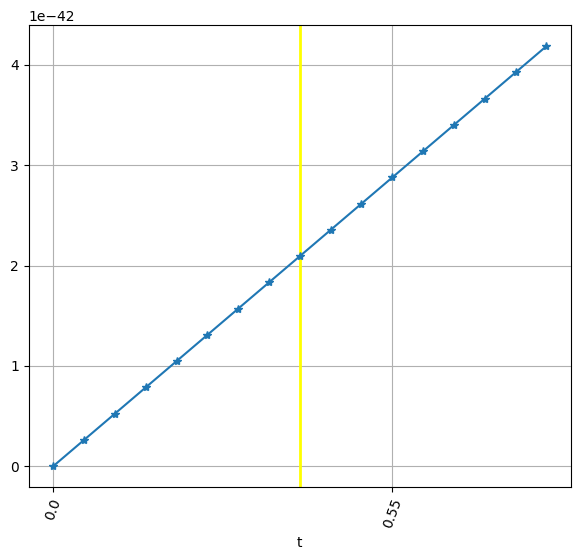

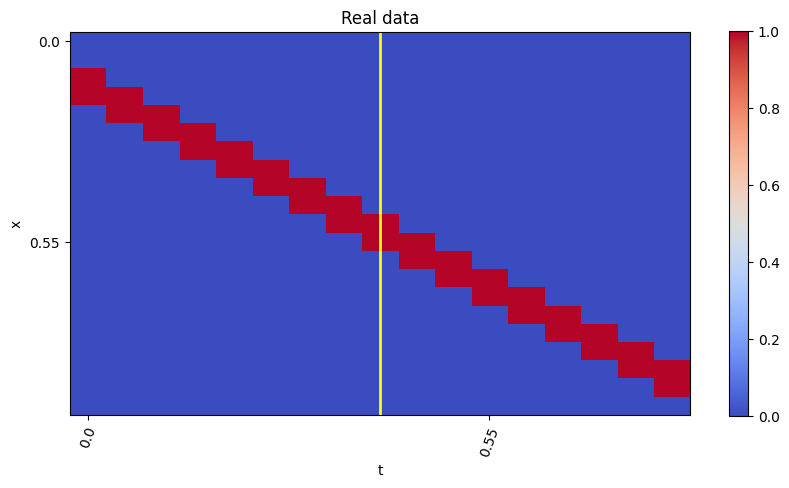

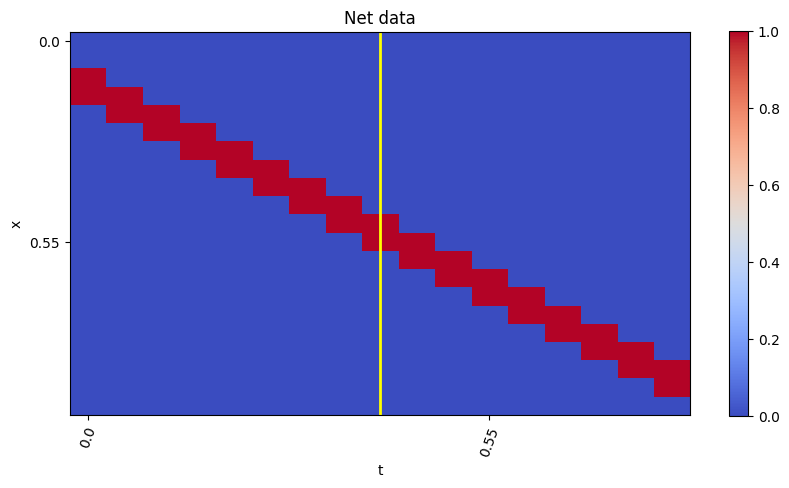

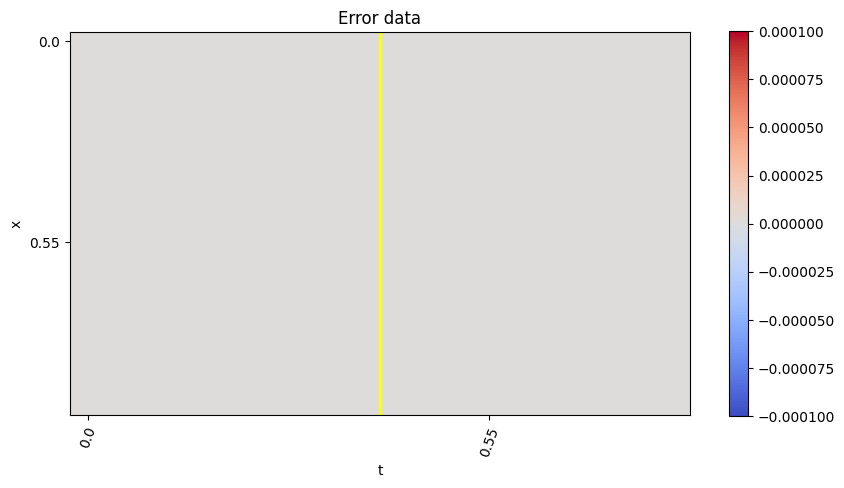

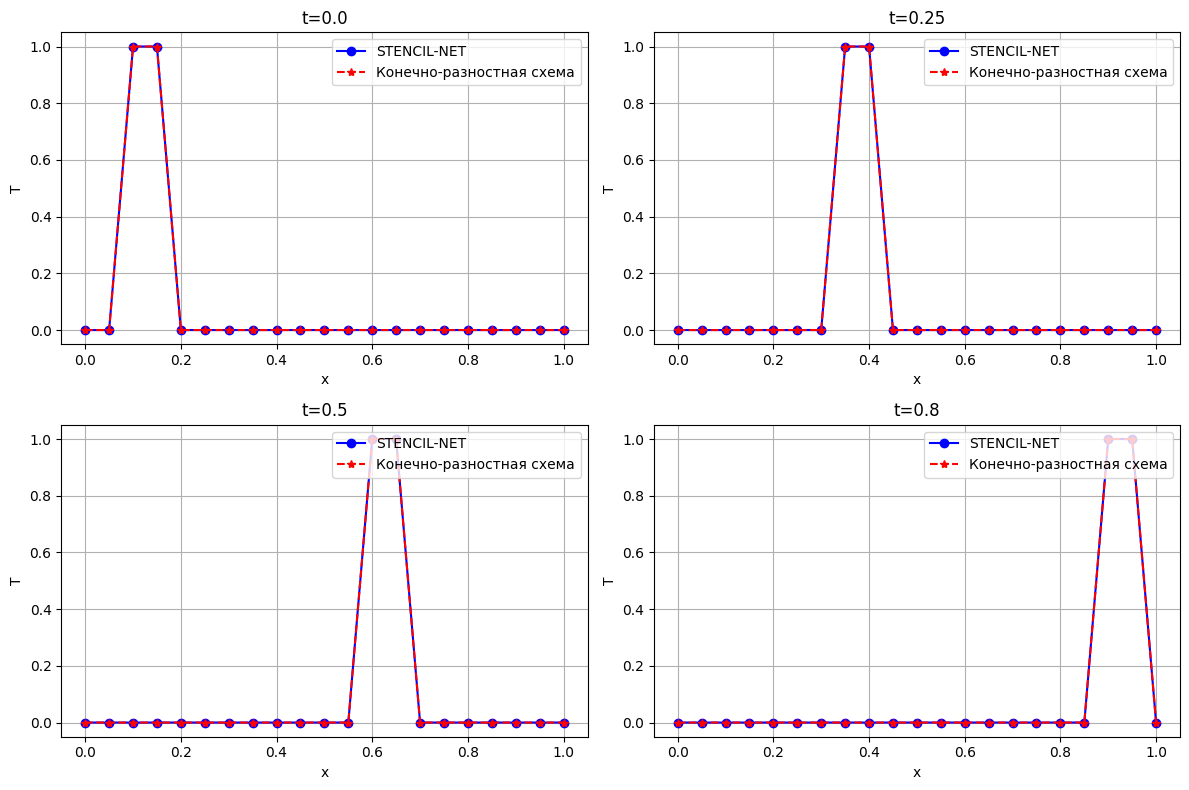



done


In [22]:
# view_results(T_sim,x_sim,NN_sim,v_coarse,T,dtc,n=10,fix_axes=True)

# view_result_imshow(NN_sim,v_coarse,T,dtc,L,dxc,figsize=(10,10))

folder='Experiment_6_part2_advection'

for i in range(len(epochs_lst)):
    
    print(fr'---------------Epochs = {epochs_lst[i]}-------------------')
    # view_results(T_sim,x_sim,NN_sim_lst[i],v_coarse,T,dtc,n=10,fix_axes=True,
    #             epochs=epochs_lst[i],
    #             save_path = fr'{folder}/graphs_n={n}/',
    #             save_name = fr'Result_epoch={epochs_lst[i]}',
    #             view_flag=False)

    view_result_metric(NN_sim_lst[i],v_coarse,T,dtc,L,dxc,
                       n_xticks=11,
                       save_path = fr'{folder}/graphs_n={n}/',
                save_name = fr'Metric_epoch={epochs_lst[i]}')
    
    view_result_imshow(NN_sim_lst[i],v_coarse,T,dtc,L,dxc,
                       v_min_diff=-1e-04,v_max_diff=1e-04,
                       n_tticks=11,
                       n_xticks=11,
                       aspect=0.5,
                       shrink=0.5,
                       save_path= fr'{folder}/graphs_n={n}/',
                       save_name='imshow_',
                       figsize=(10,10))

    make_subplot_graphs(NN_sim, v_coarse, x_sim, T_sim, T, dtc, n, nx=2, ny=2,
                        figsize=(12,8),
                        save_flg=True,
                        save_path=fr'{folder}/graphs_n={n}/',
                        save_name=fr'SUBPLOT={epochs_lst[i]}')
    
    

    print('\n')
print('done')

In [23]:
net.layer[0].weight

Parameter containing:
tensor([[ 2.0000e+01, -2.0000e+01,  1.0990e-40]], requires_grad=True)

In [24]:
# diff=NN_sim_lst[0]-v_coarse

# for j in range(len(diff[0,:])): 
#     if max(diff[:,j])!=0:
#         plt.figure()
#         plt.plot(diff[:,j],'-*')
#         plt.title(str(j)+' / '+str(len(diff[0,:])))
#         plt.grid()
        
#         plt.figure()
#         plt.plot(NN_sim_lst[0][:,j],'-*',label='NN_sim')
#         plt.plot(v_coarse[:,j],'-*',label='v_coarse')
#         plt.legend()
#         plt.grid()
        
#         break

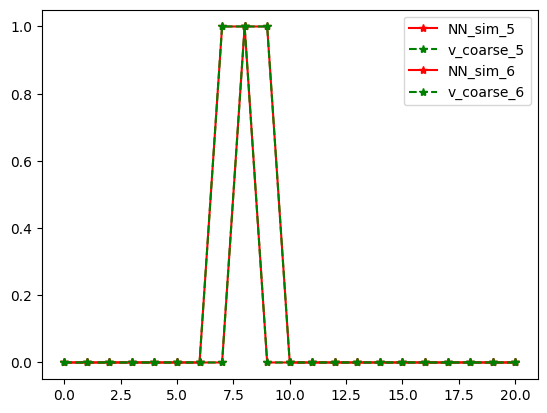

In [25]:
for j in range(5,7):
        plt.plot(NN_sim_lst[0][:,j],'-*',color='red',label=fr'NN_sim_{j}')
        # plt.plot(v_coarse[:,j],'--*',color='blue',label=fr'v_coarse_{j}')
        plt.plot(v_fact[:,j],'--*',color='green',label=fr'v_coarse_{j}')
        plt.legend()
        plt.grid()